# Import packages & functions

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
import sgm
from pkgs.MindEyeV2.src.generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder # bigG embedder

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import pkgs.MindEyeV2.src.utils as utils

import lovely_tensors as lt
lt.monkey_patch()

from csng.data import get_dataloaders
from csng.utils.mix import seed_all

DATA_PATH_BRAINREADER = os.path.join(os.environ["DATA_PATH"], "brainreader")
DATA_PATH_MINDEYE = os.path.join(os.environ["DATA_PATH"], "mindeye")
DATA_PATH_MINDEYE_CACHE = os.path.join(DATA_PATH_MINDEYE, "cache")
print(f"{DATA_PATH_BRAINREADER=}\n{DATA_PATH_MINDEYE=}\n{DATA_PATH_MINDEYE_CACHE=}")

!nvidia-smi

/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


DATA_PATH_BRAINREADER='/scratch/izar/sobotka/csng/brainreader'
DATA_PATH_MINDEYE='/scratch/izar/sobotka/csng/mindeye'
DATA_PATH_MINDEYE_CACHE='/scratch/izar/sobotka/csng/mindeye/cache'
Fri Feb 21 15:27:32 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:D8:00.0 Off |                  Off |
| N/A   34C    P0              23W / 250W |      0MiB / 32768Mi

# Configurations

In [2]:
cfg = {
    "device": "cuda",
    "data_type": torch.float32,
    "seed": 0,
    "data": {"mixing_strategy": "parallel_min", "max_training_batches": None},
    "wandb": {"project": os.environ["WANDB_PROJECT"], "group": "mindeye"},
}

### setup data config
cfg["data"]["brainreader_mouse"] = {
    "device": cfg["device"],
    "mixing_strategy": cfg["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": 1,
    # "sessions": (subj_list := list(range(1, 23))),
    "sessions": (subj_list := [1,2,3,4,5,6,7,8]),
    "resize_stim_to": (36, 64),
    "normalize_stim": True,
    "normalize_resp": True,
    "div_resp_by_std": True,
    "clamp_neg_resp": False,
    "additional_keys": None,
    "avg_test_resp": True,
    "drop_last": False,
}

### setup model config
cfg["model"] = {
    "model_name": (model_name := "csng_19-02-25_16-52"),
    "cache_dir": DATA_PATH_MINDEYE_CACHE,
    "data_path": DATA_PATH_BRAINREADER,
    "outdir": f'{DATA_PATH_MINDEYE}/train_logs/{model_name}',
    "evalsdir": f'{DATA_PATH_MINDEYE}/evals/{model_name}',
    "ckpt_saving": True,
    "ckpt_interval": 1,

    # "subj_list": [6], # list(range(1, 23))
    # "num_voxels_list": [8587],
    # "num_voxels": {
    #     f'subj06': 8587,
    # },

    "subj_list": subj_list,
    "num_voxels_list": (num_voxels_list := [dset.n_neurons for dset in get_dataloaders(config=cfg)[0]["train"]["brainreader_mouse"].datasets]),
    "num_voxels": {
        f"subj{subj:02d}": num_voxels
        for subj, num_voxels in zip(subj_list, num_voxels_list)
    },
    "hidden_dim": 768,
    "n_blocks": 4,
    "clip_scale": 1.,
    "use_prior": True,
    "prior_scale": 30,
    "num_epochs": 150,
    "num_iterations_per_epoch": 500,
    # "mixup_pct": 0.33,
    "mixup_pct": 0.,
    "blurry_recon": True,
    "blur_scale": 0.54,
    "use_image_aug": False,
}

In [3]:
### create dirs
os.makedirs(cfg["model"]["outdir"], exist_ok=True)
os.makedirs(cfg["model"]["cache_dir"], exist_ok=True)
print(cfg["model"]["outdir"])

/scratch/izar/sobotka/csng/mindeye/train_logs/csng_19-02-25_16-52


# Prep data, models, and dataloaders

In [3]:
seed_all(cfg["seed"])
dls, _ = get_dataloaders(config=cfg)
train_dl, val_dl, test_dl = dls["train"]["brainreader_mouse"], dls["val"]["brainreader_mouse"], dls["test"]["brainreader_mouse"]
train_dls = {subj_name: dl for subj_name, dl in zip(cfg["model"]["num_voxels"].keys(), train_dl.dataloaders)}
display(train_dls)

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 
cfg["model"]["num_samples_per_epoch"] = sum(len(dl) * dl.batch_size for dl in train_dls.values())
cfg["model"]["num_iterations_per_epoch"] = cfg["model"]["num_samples_per_epoch"] // (cfg["data"]["brainreader_mouse"]["batch_size"] * len(cfg["model"]["subj_list"]))

{'subj01': <torch.utils.data.dataloader.DataLoader at 0x7f521581d150>,
 'subj02': <torch.utils.data.dataloader.DataLoader at 0x7f5215819b50>,
 'subj03': <torch.utils.data.dataloader.DataLoader at 0x7f521581add0>,
 'subj04': <torch.utils.data.dataloader.DataLoader at 0x7f523f636b90>,
 'subj05': <torch.utils.data.dataloader.DataLoader at 0x7f5215820a10>,
 'subj06': <torch.utils.data.dataloader.DataLoader at 0x7f5215820990>,
 'subj07': <torch.utils.data.dataloader.DataLoader at 0x7f5215823050>,
 'subj08': <torch.utils.data.dataloader.DataLoader at 0x7f5215825150>}

dividing batch size by subj_list, which will then be concatenated across subj during training...


## Load models

### CLIP image embeddings  model

In [4]:
cfg["model"]["clip_img_embedder_arch"] = "ViT-bigG-14"
cfg["model"]["clip_img_embedder_version"] = "laion2b_s39b_b160k"
cfg["model"]["clip_seq_dim"] = 256
cfg["model"]["clip_emb_dim"] = 1664

clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch=cfg["model"]["clip_img_embedder_arch"],
    version=cfg["model"]["clip_img_embedder_version"],
    output_tokens=True,
    only_tokens=True,
    cache_dir=cfg["model"]["cache_dir"],
)
clip_img_embedder.to(cfg["device"])

FrozenOpenCLIPImageEmbedder(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-47): 48 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
            )
            (ls_2): Identity()


### SD VAE

In [5]:
if cfg["model"]["blurry_recon"]:
    ### SD VAE
    from diffusers import AutoencoderKL
    cfg["model"]["autoenc"] = {
        "down_block_types": ['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
        "up_block_types": ['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
        "block_out_channels": [128, 256, 512, 512],
        "layers_per_block": 2,
        "sample_size": 256,
    }
    autoenc = AutoencoderKL(**cfg["model"]["autoenc"])
    autoenc.load_state_dict(torch.load(f'{cfg["model"]["cache_dir"]}/sd_image_var_autoenc.pth'))
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(cfg["device"])
    utils.count_params(autoenc)

    ### VICRegL ConvNext-XL
    from pkgs.MindEyeV2.src.autoencoder.convnext import ConvnextXL
    cnx = ConvnextXL(f'{cfg["model"]["cache_dir"]}/convnext_xlarge_alpha0.75_fullckpt.pth')
    cnx.requires_grad_(False)
    cnx.eval()
    cnx.to(cfg["device"])
    utils.count_params(cnx)

    import kornia
    from kornia.augmentation.container import AugmentationSequential
    mean = torch.tensor([0.485, 0.456, 0.406]).to(cfg["device"]).reshape(1,3,1,1)
    std = torch.tensor([0.228, 0.224, 0.225]).to(cfg["device"]).reshape(1,3,1,1)
    blur_augs = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.8),
        kornia.augmentation.RandomGrayscale(p=0.1),
        kornia.augmentation.RandomSolarize(p=0.1),
        kornia.augmentation.RandomResizedCrop((224,224), scale=(.9,.9), ratio=(1,1), p=1.0),
        data_keys=["input"],
    )

param counts:
83,653,863 total
0 trainable
param counts:
349,687,808 total
0 trainable


### MindEye modules

In [6]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    
    def forward(self, x):
        return x

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer to enable regularization
    def __init__(self, input_sizes, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
            torch.nn.Linear(input_size, out_features) for input_size in input_sizes
        ])
    
    def forward(self, x, subj_idx):
        out = self.linears[subj_idx](x[:,0]).unsqueeze(1)
        return out

In [7]:
### init model
model = MindEyeModule()
model.ridge = RidgeRegression(cfg["model"]["num_voxels_list"], out_features=cfg["model"]["hidden_dim"])
utils.count_params(model.ridge)
utils.count_params(model)

# test on subject 1 with fake data
b = torch.randn((2,1,cfg["model"]["num_voxels_list"][0]))
print(b.shape, model.ridge(b,0).shape)

param counts:
50,132,736 total
50,132,736 trainable
param counts:
50,132,736 total
50,132,736 trainable
torch.Size([2, 1, 9395]) torch.Size([2, 1, 768])


In [8]:
from pkgs.MindEyeV2.src.models import BrainNetwork

### backbone
cfg["model"]["brainnetwork"] = {
    "h": cfg["model"]["hidden_dim"],
    "in_dim": cfg["model"]["hidden_dim"],
    "seq_len": 1,
    "n_blocks": cfg["model"]["n_blocks"],
    "clip_size": cfg["model"]["clip_emb_dim"],
    "out_dim": cfg["model"]["clip_emb_dim"] * cfg["model"]["clip_seq_dim"],
    "blurry_recon": cfg["model"]["blurry_recon"],
    "clip_scale": cfg["model"]["clip_scale"],
}
model.backbone = BrainNetwork(**cfg["model"]["brainnetwork"])
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,1,cfg["model"]["hidden_dim"]))
print("b.shape",b.shape)

backbone_, clip_, blur_ = model.backbone(b)
print(backbone_.shape, clip_.shape, blur_[0].shape, blur_[1].shape)

param counts:
345,356,284 total
345,356,284 trainable
param counts:
395,489,020 total
395,489,020 trainable
b.shape torch.Size([2, 1, 768])
torch.Size([2, 256, 1664]) torch.Size([2, 256, 1664]) torch.Size([2, 4, 28, 28]) torch.Size([2, 49, 512])


### Adding diffusion prior + unCLIP if use_prior=True

In [9]:
if cfg["model"]["use_prior"]:
    from pkgs.MindEyeV2.src.models import *

    ### setup diffusion prior network
    cfg["model"]["out_dim"] = cfg["model"]["clip_emb_dim"]
    cfg["model"]["depth"] = 6
    cfg["model"]["dim_head"] = 52
    cfg["model"]["heads"] = cfg["model"]["clip_emb_dim"] // cfg["model"]["dim_head"]
    cfg["model"]["timesteps"] = 100
    cfg["model"]["prior_network"] = {
        "dim": cfg["model"]["out_dim"],
        "depth": cfg["model"]["depth"],
        "dim_head": cfg["model"]["dim_head"],
        "heads": cfg["model"]["heads"],
        "causal": False,
        "num_tokens": cfg["model"]["clip_seq_dim"],
        "learned_query_mode": "pos_emb",
    }
    cfg["model"]["brain_diffusion_prior"] = {
        "image_embed_dim": cfg["model"]["out_dim"],
        "condition_on_text_encodings": False,
        "timesteps": cfg["model"]["timesteps"],
        "cond_drop_prob": 0.2,
        "image_embed_scale": None,
    }

    prior_network = PriorNetwork(**cfg["model"]["prior_network"])
    model.diffusion_prior = BrainDiffusionPrior(net=prior_network, **cfg["model"]["brain_diffusion_prior"])
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)

param counts:
259,865,216 total
259,865,200 trainable
param counts:
655,354,236 total
655,354,220 trainable


### Setup optimizer / lr / ckpt saving

In [10]:
cfg["model"]["optimization"] = {
    "no_decay": ['bias', 'LayerNorm.bias', 'LayerNorm.weight'],
    "max_lr": 3e-4,
    "lr_scheduler_type": 'cycle',
}

opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 0.0},
]
if cfg["model"]["use_prior"]:
    opt_grouped_parameters.extend([
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if not any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 0.0}
    ])

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=cfg["model"]["optimization"]["max_lr"])

if cfg["model"]["optimization"]["lr_scheduler_type"] == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=cfg["model"]["num_epochs"]*cfg["model"]["num_iterations_per_epoch"],
        last_epoch=-1
    )
elif cfg["model"]["optimization"]["lr_scheduler_type"] == 'cycle':
    cfg["model"]["optimization"]["total_steps"] = int(np.floor(cfg["model"]["num_epochs"]*cfg["model"]["num_iterations_per_epoch"]))
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=cfg["model"]["optimization"]["max_lr"],
        total_steps=cfg["model"]["optimization"]["total_steps"],
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/cfg["model"]["num_epochs"],
    )
    print("total_steps", cfg["model"]["optimization"]["total_steps"])

def save_ckpt(tag):
    ckpt_path = cfg["model"]["outdir"]+f'/{tag}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'train_losses': losses,
        'test_losses': test_losses,
        'lrs': lrs,
        "cfg": cfg,
        "best": best,
    }, ckpt_path)
    print(f"\n---saved {cfg['model']['outdir']}/{tag} ckpt!---\n")

def load_ckpt(tag):
    ckpt_path = cfg["model"]["outdir"]+f'/{tag}.pth'
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    epoch = checkpoint['epoch']
    losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    lrs = checkpoint['lrs']
    best = checkpoint['best']
    optimizer.zero_grad()
    print(f"\n---loaded {cfg['model']['outdir']}/{tag} ckpt!---\n")
    return epoch, losses, test_losses, lrs, checkpoint["cfg"], best

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 675000

Done with model preparations!
param counts:
655,354,236 total
655,354,220 trainable


In [11]:
model

MindEyeModule(
  (ridge): RidgeRegression(
    (linears): ModuleList(
      (0): Linear(in_features=9395, out_features=768, bias=True)
      (1): Linear(in_features=6721, out_features=768, bias=True)
      (2): Linear(in_features=6864, out_features=768, bias=True)
      (3): Linear(in_features=8784, out_features=768, bias=True)
      (4): Linear(in_features=8739, out_features=768, bias=True)
      (5): Linear(in_features=8587, out_features=768, bias=True)
      (6): Linear(in_features=8890, out_features=768, bias=True)
      (7): Linear(in_features=7289, out_features=768, bias=True)
    )
  )
  (backbone): BrainNetwork(
    (mixer_blocks1): ModuleList(
      (0-3): 4 x Sequential(
        (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (1): Sequential(
          (0): Linear(in_features=768, out_features=768, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.15, inplace=False)
          (3): Linear(in_features=768, out_features=768, bias=Tr

In [18]:
epoch, losses, test_losses, lrs, cfg, best = load_ckpt("last")


---loaded /scratch/izar/sobotka/csng/mindeye/train_logs/csng_19-02-25_16-52/last ckpt!---



# Weights and Biases

In [13]:
if cfg.get("wandb", None) is not None: # only use main process for wandb logging
    import wandb
    wandb_log = wandb.init(
        id=cfg["model"]["model_name"],
        name=cfg["model"]["model_name"],
        config=cfg,
        resume="allow",
        **cfg["wandb"],
    )
else:
    wandb_log = False

wandb: Currently logged in as: johnny1188 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


# Main

In [14]:
### img transform (1x36x64 -> 3x224x224)
img_tform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.Lambda(lambda x: x.repeat(1, 3, 1, 1)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
if cfg["model"]["use_image_aug"]:
    img_augment = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )

In [ ]:
### tracking
# epoch = 0
# losses, test_losses, lrs = [], [], []
# best = {"loss": 1e9, "epoch": 0}
torch.cuda.empty_cache()

### optimization
mse = nn.MSELoss()
l1 = nn.L1Loss()
cfg["model"]["cos_anneal_start"] = 0.004
cfg["model"]["cos_anneal_end"] = 0.0075
soft_loss_temps = utils.cosine_anneal(
    cfg["model"]["cos_anneal_start"],
    cfg["model"]["cos_anneal_end"],
    cfg["model"]["num_epochs"] - int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"])
)

### run
model.to(cfg["device"])
progress_bar = tqdm(range(epoch, cfg["model"]["num_epochs"]), ncols=1200, disable=False)
seed_all(cfg["seed"])
for epoch in progress_bar:
    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    recon_cossim = 0.
    recon_mse = 0.
    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_blurry_cont_total = 0.
    loss_prior_total = 0.
    blurry_pixcorr = 0.

    train_dl = get_dataloaders(config=cfg)[0]["train"]["brainreader_mouse"]

    ### train
    model.train()
    for train_i, batch in enumerate(train_dl):
        if train_i % 50 == 0:
            print(f"[E{epoch}/{cfg['model']['num_epochs']} I{train_i}/{cfg['model']['num_iterations_per_epoch']}]")
        with torch.cuda.amp.autocast(dtype=cfg["data_type"]):
            optimizer.zero_grad()
            loss = 0.

            ### select data
            voxel_list = [dp["resp"].unsqueeze(1).to(cfg["device"]) for dp in batch]  # (B, 1, num_voxels = num_of_neurons)
            image = img_tform(torch.cat([dp["stim"] for dp in batch], dim=0).to(cfg["device"]))  # (B, 3, 224, 224)

            ### augment image
            if cfg["model"]["use_image_aug"]: 
                image = img_augment(image)

            if epoch < int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"]):
                perm_list = [perm_iters[f"subj0{s}_iter{train_i}"].detach().to(cfg["device"]) for s in cfg["model"]["subj_list"]]
                perm = torch.cat(perm_list, dim=0)
                betas_list = [betas_iters[f"subj0{s}_iter{train_i}"].detach().to(cfg["device"]) for s in cfg["model"]["subj_list"]]
                betas = torch.cat(betas_list, dim=0).to(cfg["data_type"])
                select_list = [select_iters[f"subj0{s}_iter{train_i}"].detach().to(cfg["device"]) for s in cfg["model"]["subj_list"]]
                select = torch.cat(select_list, dim=0)

            ### map voxels to clip space
            voxel_ridge = torch.cat([model.ridge(voxel_list[si], si) for si, s in enumerate(cfg["model"]["subj_list"])], dim=0)
            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            ### map GT image to clip space
            clip_target = clip_img_embedder(image)
            assert not torch.any(torch.isnan(clip_target))

            ### normalize clip embeddings
            if cfg["model"]["clip_scale"] > 0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if cfg["model"]["use_prior"]:
                loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                if torch.isnan(loss_prior).any():
                    print(f"  Loss prior is NaN, skipping...")
                    del backbone, clip_voxels, blurry_image_enc_, clip_target, clip_voxels_norm, clip_target_norm, loss_prior, prior_out
                    import gc
                    gc.collect()
                    torch.cuda.empty_cache()
                    continue
                for i in range(3):
                    if torch.isnan(loss_prior).any():
                        print(f"  Loss prior is NaN, trying again...")
                        del loss_prior, prior_out
                        torch.cuda.empty_cache()
                        loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                    else:
                        break

                loss_prior_total += loss_prior.item()
                loss_prior *= cfg["model"]["prior_scale"]
                loss += loss_prior

                recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                recon_mse += mse(prior_out, clip_target).item()

            if cfg["model"]["clip_scale"] > 0:
                if epoch < int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"]):
                    loss_clip = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006,
                        perm=perm, betas=betas, select=select)
                else:
                    epoch_temp = soft_loss_temps[epoch - int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"])]
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp,
                    )

                loss_clip_total += loss_clip.item()
                loss_clip *= cfg["model"]["clip_scale"]
                loss += loss_clip

            if cfg["model"]["blurry_recon"]:     
                image_enc_pred, transformer_feats = blurry_image_enc_

                # image_enc = autoenc.encode(2 * image - 1).latent_dist.mode() * 0.18215
                image_enc = autoenc.encode(image).latent_dist.mode() * 0.18215  # already z-scored
                loss_blurry = l1(image_enc_pred, image_enc)
                loss_blurry_total += loss_blurry.item()

                if epoch < int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"]):
                    image_enc_shuf = image_enc[perm]
                    betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
                    image_enc[select] = image_enc[select] * betas[select].reshape(*betas_shape) + \
                        image_enc_shuf[select] * (1 - betas[select]).reshape(*betas_shape)

                # image_norm = (image - mean) / std
                image_norm = image  # already z-scored
                # print(f"  Blurring Aug {image_norm.shape}")
                # image_aug = (blur_augs(image) - mean) / std
                image_aug = blur_augs(image)  # already z-scored
                _, cnx_embeds = cnx(image_norm)
                _, cnx_aug_embeds = cnx(image_aug)

                cont_loss = utils.soft_cont_loss(
                    nn.functional.normalize(transformer_feats.reshape(-1, transformer_feats.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_aug_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    temp=0.2)
                loss_blurry_cont_total += cont_loss.item()

                loss += (loss_blurry + 0.1 * cont_loss) * cfg["model"]["blur_scale"] #/.18215

            if cfg["model"]["clip_scale"]>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            if cfg["model"]["blurry_recon"]:
                with torch.no_grad():
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                    # blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    blurry_pixcorr += pixcorr.item()

            if train_i % 50 == 0:
                print(f"  Loss {loss.item()}")
            utils.check_loss(loss)
            # accelerator.backward(loss)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            if cfg["model"]["optimization"]["lr_scheduler_type"] is not None:
                lr_scheduler.step()

            optimizer.zero_grad()
            torch.cuda.empty_cache()

    ### evaluate
    print("\n---Evaluating---\n")
    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=cfg["data_type"]):
        n_minibatches = 0
        test_loss=0.
        test_loss_clip_total = 0.
        test_loss_prior_total = 0.
        test_blurry_pixcorr = 0.
        test_fwd_percent_correct = 0.
        test_bwd_percent_correct = 0.
        eval_dl = get_dataloaders(config=cfg)[0]["val"]["brainreader_mouse"]
        for batch in eval_dl:
            voxel_list = [dp["resp"].unsqueeze(1).to(cfg["device"]) for dp in batch]  # (B, 1, num_voxels = num_of_neurons)
            image = img_tform(torch.cat([dp["stim"] for dp in batch], dim=0).to(cfg["device"]))  # (B, 3, 224, 224)

            voxel_ridge = torch.cat([model.ridge(voxel_list[si], si) for si, s in enumerate(cfg["model"]["subj_list"])], dim=0)
            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            clip_target = clip_img_embedder(image.float())
            if cfg["model"]["clip_scale"]>0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if cfg["model"]["use_prior"]:
                loss_prior, _ = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                test_loss_prior_total += loss_prior.item()
                loss_prior *= cfg["model"]["prior_scale"]
                test_loss += loss_prior

            if cfg["model"]["clip_scale"]>0:
                loss_clip = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006,
                )

                test_loss_clip_total += loss_clip.item()
                loss_clip = loss_clip * cfg["model"]["clip_scale"]
                test_loss += loss_clip

            if cfg["model"]["blurry_recon"]:
                image_enc_pred, _ = blurry_image_enc_
                # blurry_recon_images = (autoenc.decode(image_enc_pred/0.18215).sample / 2 + 0.5).clamp(0,1)
                blurry_recon_images = (autoenc.decode(image_enc_pred/0.18215).sample)
                pixcorr = utils.pixcorr(image, blurry_recon_images)
                test_blurry_pixcorr += pixcorr.item()

            if cfg["model"]["clip_scale"]>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            n_minibatches += 1

        test_loss /= n_minibatches
        test_loss_clip_total /= n_minibatches
        test_loss_prior_total /= n_minibatches
        test_blurry_pixcorr /= n_minibatches
        test_fwd_percent_correct /= n_minibatches
        test_bwd_percent_correct /= n_minibatches

        utils.check_loss(test_loss)                
        test_losses.append(test_loss.item())

        if test_loss.item() < best["loss"]:
            save_ckpt(f'best')
            best["loss"] = test_loss.item()
            best["epoch"] = epoch

        logs = {
            "train/loss": np.mean(losses[-(train_i+1):]),
            "test/loss": test_loss.item(),
            "train/lr": lrs[-1],
            "train/num_steps": len(losses),
            "test/num_steps": len(test_losses),
            "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
            "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
            "test/test_fwd_pct_correct": test_fwd_percent_correct,
            "test/test_bwd_pct_correct": test_bwd_percent_correct,
            "train/loss_clip_total": loss_clip_total / (train_i + 1),
            "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
            "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
            "test/loss_clip_total": test_loss_clip_total,
            "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
            "test/blurry_pixcorr": test_blurry_pixcorr,
            "train/recon_cossim": recon_cossim / (train_i + 1),
            "train/recon_mse": recon_mse / (train_i + 1),
            "train/loss_prior": loss_prior_total / (train_i + 1),
            "test/loss_prior": test_loss_prior_total,
        }

        # if finished training, save jpg recons if they exist
        if (epoch == cfg["model"]["num_epochs"]-1) or (epoch % cfg["model"]["ckpt_interval"] == 0):
            if cfg["model"]["blurry_recon"]:    
                # image_enc = autoenc.encode(2*image[:4]-1).latent_dist.mode() * 0.18215
                image_enc = autoenc.encode(image[:4]).latent_dist.mode() * 0.18215  # already z-scored
                # transform blurry recon latents to images and plot it
                fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                jj=-1
                for j in [0,1,2,3]:
                    jj+=1
                    # axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].imshow(utils.torch_to_Image(autoenc.decode(image_enc[[j]]/0.18215).sample))
                    axes[jj].axis('off')
                    jj+=1
                    # axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc_pred[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].imshow(utils.torch_to_Image(autoenc.decode(image_enc_pred[[j]]/0.18215).sample))
                    axes[jj].axis('off')

                if wandb_log:
                    logs[f"test/blur_recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                    plt.close()
                else:
                    plt.show()

        progress_bar.set_postfix(**logs)

        if wandb_log: wandb.log(logs)

    # Save model checkpoint and reconstruct
    # if (ckpt_saving) and (epoch % ckpt_interval == 0):
    if (epoch + 1) % 10 == 0:
        save_ckpt(f'ep{epoch}')
    save_ckpt(f'last')

    # wait for other GPUs to catch up if needed
    # accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    print(f"Finished epoch {epoch} / {cfg['model']['num_epochs']}")
    
    plt.imshow(blurry_recon_images[0].permute(1,2,0).cpu().detach().to(torch.float32))
    plt.show()
    plt.imshow(image[0].permute(1,2,0).cpu().detach().to(torch.float32))
    plt.show()
    plt.plot(losses)
    plt.show()
    plt.plot(test_losses)
    plt.show()

print("\n===Finished!===\n")
save_ckpt(f'last')

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

[E17/150 I0/4500]


/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  Loss 7.374719142913818
tensor grad AddBackward0 cuda:0 7.375
tensor[1664, 6656] n=11075584 (42Mb) x∈[-0.452, 0.715] μ=1.733e-09 σ=0.001 cuda:0
tensor grad AddBackward0 cuda:0 14.555
tensor[1664, 6656] n=11075584 (42Mb) x∈[-0.454, 0.719] μ=-1.089e-09 σ=0.001 cuda:0
tensor grad AddBackward0 cuda:0 8.995
tensor[1664, 6656] n=11075584 (42Mb) x∈[-0.449, 0.711] μ=-4.563e-09 σ=0.001 cuda:0
tensor grad AddBackward0 cuda:0 11.644
tensor[1664, 6656] n=11075584 (42Mb) x∈[-0.444, 0.704] μ=-9.139e-09 σ=0.001 cuda:0
tensor grad AddBackward0 cuda:0 8.501
tensor[1664, 6656] n=11075584 (42Mb) x∈[-0.444, 0.704] μ=-8.042e-09 σ=0.001 cuda:0
tensor grad AddBackward0 cuda:0 11.625
tensor[1664, 6656] n=11075584 (42Mb) x∈[-0.393, 0.628] μ=-5.113e-08 σ=0.001 cuda:0
tensor grad AddBackward0 cuda:0 10.505
tensor[1664, 6656] n=11075584 (42Mb) x∈[-0.388, 0.620] μ=-5.908e-08 σ=0.001 cuda:0
tensor grad AddBackward0 cuda:0 11.852
tensor[1664, 6656] n=11075584 (42Mb) x∈[-0.293, 0.480] μ=-6.507e-08 σ=0.001 cuda:0
ten

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

tensor grad AddBackward0 cuda:0 11.916


KeyboardInterrupt: 

In [ ]:
loss.backward()
print(model.diffusion_prior.net.causal_transformer.layers[4][1][5].weight.grad)

tensor[1664, 6656] n=11075584 (42Mb) x∈[-0.333, 0.529] μ=4.843e-14 σ=0.001 cuda:0


In [65]:
optimizer.step()

In [70]:
for n,p in model.named_parameters():
    # print(n,p.grad)
    if p.grad is not None and torch.isnan(p.grad).any():
        print(f"  {n} has NaN values")

  diffusion_prior.net.causal_transformer.layers.4.1.5.weight has NaN values


In [34]:
import torch
import torch.nn as nn

# Get the weight matrix
weight_matrix = model.diffusion_prior.net.causal_transformer.layers[4][1][5].weight

# Check initial state
print(f"Initial NaN count: {torch.isnan(weight_matrix).sum().item()}")
print(f"requires_grad: {weight_matrix.requires_grad}")

# Create a mask for NaN values
nan_mask = torch.isnan(weight_matrix)

# Generate random values from uniform distribution (e.g., between -0.1 and 0.1)
random_values = torch.rand_like(weight_matrix, dtype=weight_matrix.dtype, 
                              device=weight_matrix.device) * 0.2 - 0.1  # Scale to [-0.1, 0.1]

# Replace NaN values using torch.where (non-in-place)
new_weight_matrix = torch.where(nan_mask, random_values, weight_matrix)

# Verify no NaNs in the new tensor before assignment
print(f"NaN count in new_weight_matrix before assignment: {torch.isnan(new_weight_matrix).sum().item()}")

# Reassign to the model parameter
model.diffusion_prior.net.causal_transformer.layers[4][1][5].weight = nn.Parameter(
    new_weight_matrix, requires_grad=weight_matrix.requires_grad
)

# Verify the update in the model
updated_weight_matrix = model.diffusion_prior.net.causal_transformer.layers[4][1][5].weight
print(f"Number of NaN values after reinitialization: {torch.isnan(updated_weight_matrix).sum().item()}")
print(f"requires_grad preserved: {updated_weight_matrix.requires_grad}")

Initial NaN count: 0
requires_grad: True
NaN count in new_weight_matrix before assignment: 0
Number of NaN values after reinitialization: 0
requires_grad preserved: True


In [75]:
for n,p in model.named_parameters():
    if torch.isnan(p).any():
        print(f"  {n} has NaN values")

In [18]:
def save_ckpt(tag):
    ckpt_path = cfg["model"]["outdir"]+f'/{tag}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'train_losses': losses,
        'test_losses': test_losses,
        'lrs': lrs,
        "cfg": cfg,
        "best": best,
    }, ckpt_path)
    print(f"\n---saved {cfg['model']['outdir']}/{tag} ckpt!---\n")


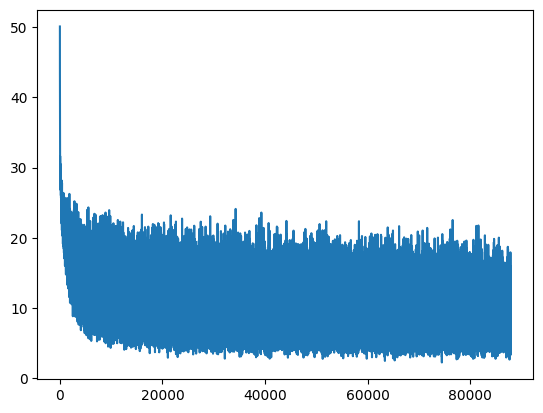

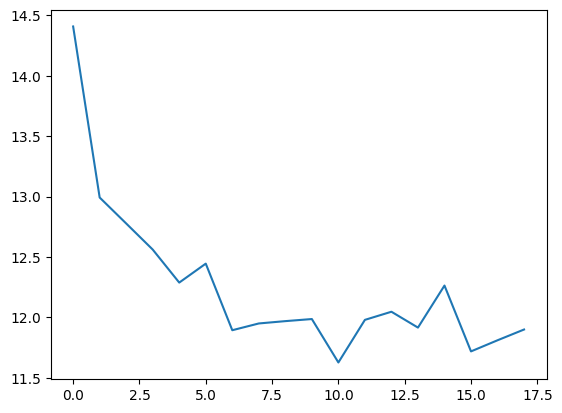

In [71]:
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()